<a href="https://colab.research.google.com/github/akshaytripathi09/FIRE-SMOKE-DETECTION-OPEN-CV-/blob/main/FIRE_%26_SMOKE_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MOUNTING DATA FROM GOOGLE DRIVE

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPORT LIBRARIES

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import os
import cv2
import matplotlib.pyplot as plt
import random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# DEFINE CONSTANTS

In [4]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# PREPARE TRAINING DATA

In [67]:
filenames = os.listdir("/content/drive/MyDrive/OPENCV BASICS/FIRE & SMOKE DETECTION/Fire")
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'fire':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [68]:
df.head()

,filename,category
0,141.jpg,0
1,177 (1).jpg,0
2,163.jpg,0
3,68.jpg,0
4,0.jpg,0


In [69]:
df.tail()

,filename,category
203,166.jpg,0
204,184.jpg,0
205,169.jpg,0
206,43.jpg,0
207,105.jpg,0


# SEE TOTAL IN COUNT

<Axes: xlabel='category'>

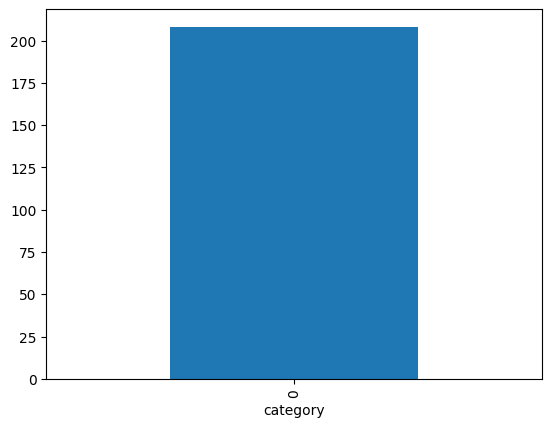

In [8]:
df['category'].value_counts().plot.bar()

# SEE SAMPLES IMAGES

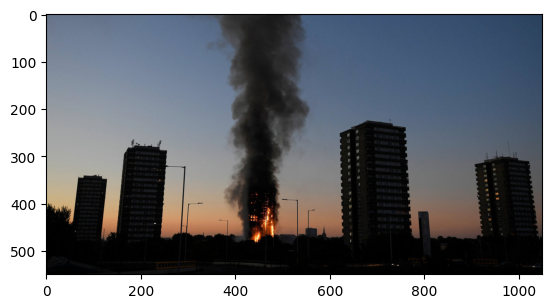

In [29]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/OPENCV BASICS/FIRE & SMOKE DETECTION/Fire/" +sample)
plt.imshow(image)

####

1-Input Layer: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.


2-Conv Layer: This layer will extract features from image.

3-Pooling Layer: This layerreduce the spatial volume of input image after convolution.

4-Fully Connected Layer: It connect the network from a layer to another layer

5-Output Layer: It is the predicted values layer.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3,3), activation = 'relu', input_shape= (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation= 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation ='softmax'))

model.compile(loss= 'categorical_crossentropy', optimizer= 'rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

# CALLBACKS

## Early Stop
To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

## Learning Rate Reduction
We will reduce the learning rate when then accuracy not increase for 2 steps

In [11]:
earlystop = EarlyStopping(patience =10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]


# PREPARE DATA

### Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

#### So we will convert 1 to fire and 0 to smoke

In [30]:
df["category"] = df["category"].replace({0: 'Fire', 1: 'Smoke'})

In [31]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

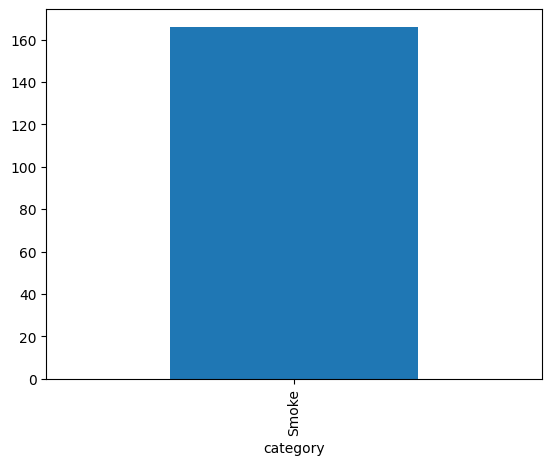

In [32]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

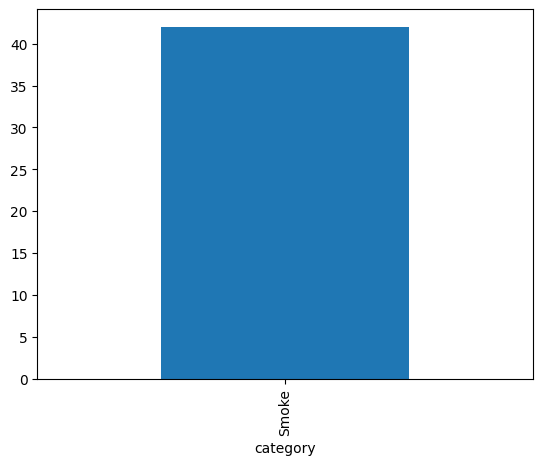

In [33]:
validate_df['category'].value_counts().plot.bar()

In [16]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size= 15

# TRAINING GENERATOR

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/OPENCV BASICS/FIRE & SMOKE DETECTION/Fire/",
    x_col= 'filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size

)

Found 166 validated image filenames belonging to 1 classes.


# VALIDATION GENERATOR

In [18]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/MyDrive/OPENCV BASICS/FIRE & SMOKE DETECTION/Fire/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 42 validated image filenames belonging to 1 classes.


# SEE HOW GENERATOR WORKS

In [19]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/drive/MyDrive/OPENCV BASICS/FIRE & SMOKE DETECTION/Fire/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'

)

Found 1 validated image filenames belonging to 1 classes.


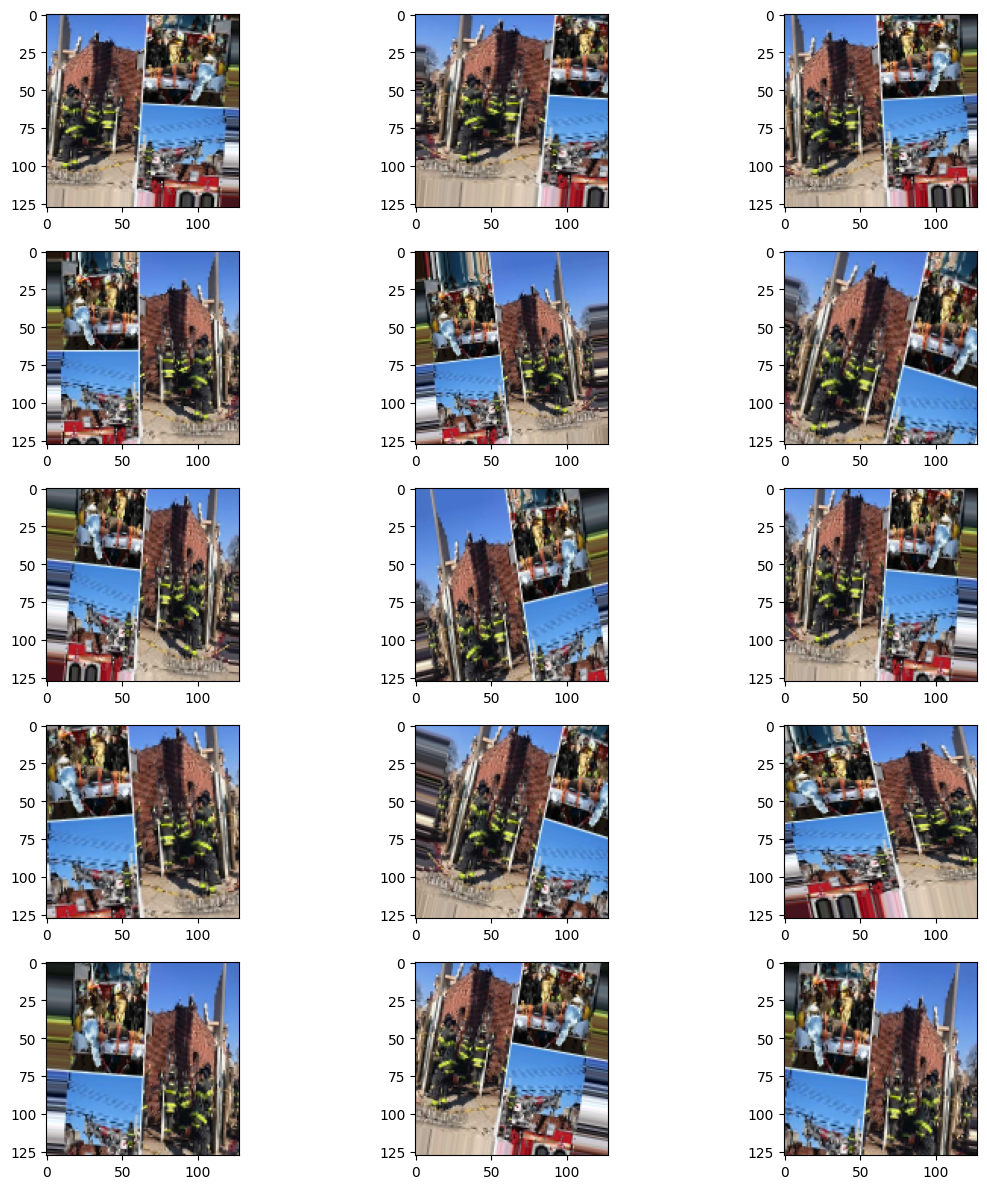

In [66]:
plt.figure(figsize=(12,12))
for i in range(0,15):
  plt.subplot(5,3, i+1)
  for X_batch, Y_batch in example_generator:
    image = X_batch[0]
    plt.imshow(image)
    break
plt.tight_layout()
plt.show()

# FIT MODEL

In [21]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs= epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
model.save("fire_detection.h5")

<ipython-input-21-b4edde3815c1>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
11/11 [==============================] - 21s 2s/step - loss: 3.6660 - accuracy: 0.4901 - val_loss: 1.9875 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 14s 1s/step - loss: 2.3716 - accuracy: 0.5232 - val_loss: 1.5960 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 2.5371 - accuracy: 0.5033
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
11/11 [==============================] - 21s 2s/step - loss: 2.5371 - accuracy: 0.5033 - val_loss: 1.6662 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 15s 1s/step - loss: 2.1889 - accuracy: 0.4967 - val_loss: 2.6158 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 5/50
11/11 [==============================] - ETA: 0s - loss: 2.0547 - accuracy: 0.5033
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
11/11 [==============================] - 15s 1s/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# VISUALIZE TRAINING

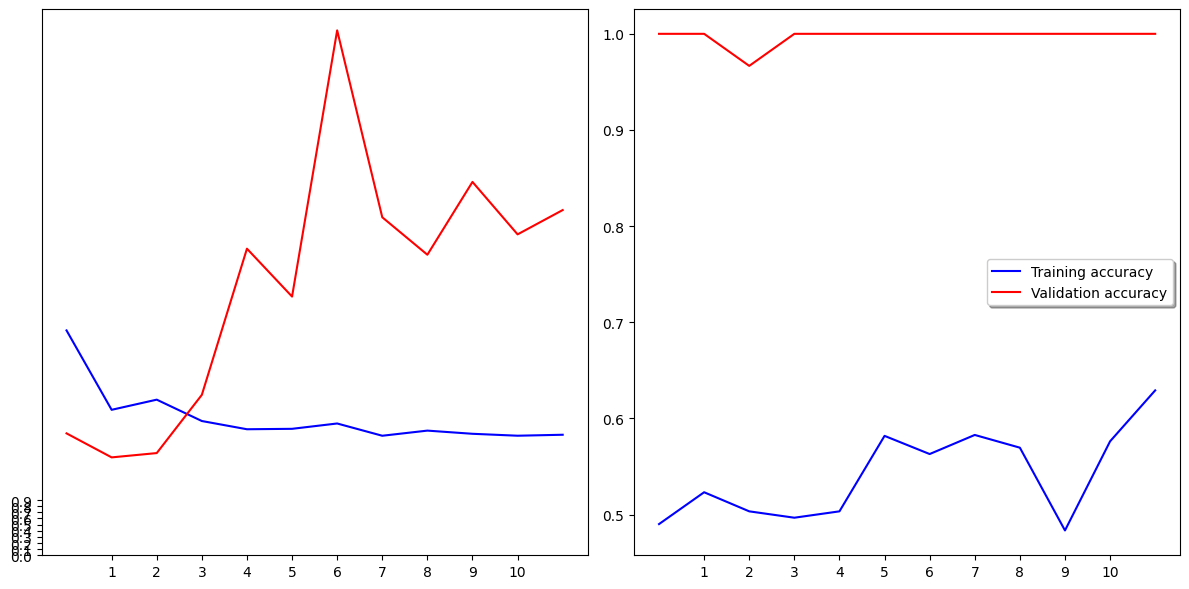

In [65]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize= (12,6))
ax1.plot(history.history['loss'], color ='b', label="Training Loss")
ax1.plot(history.history['val_loss'], color ='r', label="Validation Loss")
ax1.set_xticks(np.arange(1, 11, 1))
ax1.set_yticks(np.arange(0,1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, 11, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# CONFUSION MATRIX

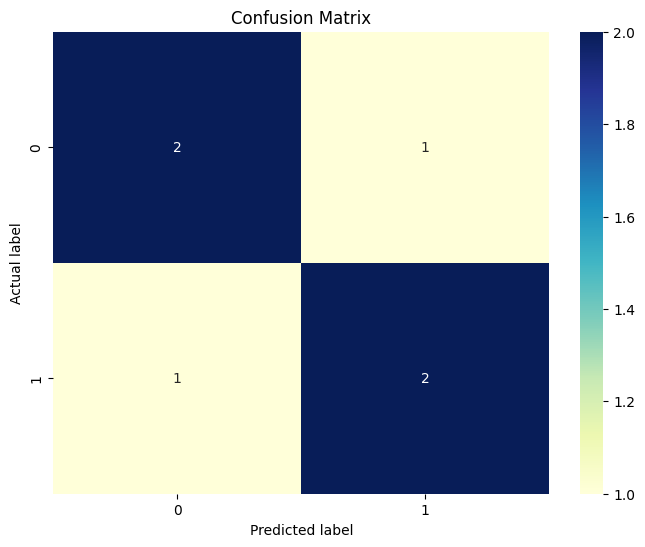

In [53]:
# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some example data
y_test = [0, 1, 0, 1, 0, 1]  # Example true labels
y_pred = [0, 1, 0, 0, 1, 1]  # Example predicted labels


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# CLASSIFICATION REPORT

In [54]:
# Calculate and print the Classification Report with zero_division parameter
from sklearn.metrics import classification_report

class_report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.67      0.67      0.67         3

    accuracy                           0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



In [55]:
# PREDICTION
result = model.predict(validation_generator,batch_size = batch_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_test = validation_generator.labels

# Evaluvate
loss,acc = model.evaluate(validation_generator, batch_size = batch_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 100.0
The Loss of the model for testing data is: 5.574897289276123


1/1 [==============================] - 0s 216ms/step
Fire


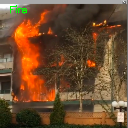

1/1 [==============================] - 0s 36ms/step
Fire


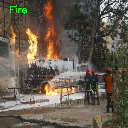

1/1 [==============================] - 0s 35ms/step
Fire


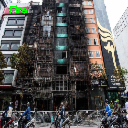

1/1 [==============================] - 0s 39ms/step
Fire


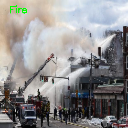

1/1 [==============================] - 0s 37ms/step
Fire


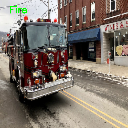

1/1 [==============================] - 0s 34ms/step
Fire


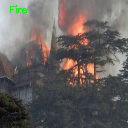

1/1 [==============================] - 0s 36ms/step
Fire


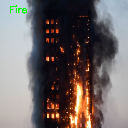

1/1 [==============================] - 0s 34ms/step
Fire


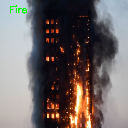

1/1 [==============================] - 0s 57ms/step
Fire


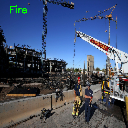

1/1 [==============================] - 0s 56ms/step
Fire


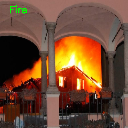

In [23]:
from google.colab.patches import cv2_imshow
import cv2
import os
import random

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

for i in range(10):
    all_test_images = os.listdir('/content/drive/MyDrive/OPENCV BASICS/FIRE & SMOKE DETECTION/Output/testing')
    random_image = random.choice(all_test_images)
    img = cv2.imread(f'/content/drive/MyDrive/OPENCV BASICS/FIRE & SMOKE DETECTION/Output/testing/{random_image}')
    img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))

    org = img.copy()
    img = img.reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

    pred = model.predict(img)
    print(['Fire', 'Smoke'][int(pred[0][0])])
    cv2_imshow(org)
    cv2.waitKey(0)

cv2.destroyAllWindows()

In [56]:
!pip install gradio==3.50

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.9 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=5584 sha256=63a4d8e16ee51e40058075ffbca5e551be50c369eeb5a38f6ddcae52f5189eeb


In [57]:
import gradio as gr
from tensorflow.keras.models import load_model

In [58]:
from google.colab import drive
drive.mount ('/content/drive')

import os
os.chdir("/content/drive/MyDrive/OPENCV BASICS/FIRE & SMOKE DETECTION")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
!dir

Fire  Output


In [61]:
model = load_model("/content/drive/MyDrive/OPENCV BASICS/FIRE & SMOKE DETECTION/Output/fire_detection.h5")


In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_4 (Separa  (None, 128, 128, 16)      211       
 bleConv2D)                                                      
                                                                 
 activation_7 (Activation)   (None, 128, 128, 16)      0         
                                                                 
 batch_normalization_6 (Bat  (None, 128, 128, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 separable_conv2d_5 (Separa  (None, 64, 64, 32)        688       
 bleConv2D)                                           

# INFRENCE PIPELINE

In [63]:
import cv2

def predict(Image):
    img = cv2.resize(Image, (128, 128))  # Correct usage of cv2.resize
    img = img.reshape(1, 128, 128, 3)
    preds = model.predict(img)[0]
    result = dict()
    result["Cat"] = round(float(list(preds)[0]), 3)
    result["Dog"] = round(float(list(preds)[1]), 3)
    return result


In [64]:
im = gr.Image()
label =  gr.Label(num_top_classes = 2)

gr.Interface(fn=predict,
             inputs=im,
             outputs=label,
             title="CNN Demo" ).launch (share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://6c208d73d65bcf988f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
